**Model Creation**

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import joblib

In [126]:
# Import Data
df = pd.read_csv("../../data/processed/heart_processed_encoded.csv")

In [127]:
# Split Data
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random Forest Classifier**

In [128]:
# Create Model
rf = RandomForestClassifier(random_state=42)

In [129]:
# Fit Model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [130]:
# Make Predictions
rf_pred = rf.predict(X_test)

In [131]:
accuracy = accuracy_score(y_test, rf_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


In [132]:
# Feature Importance
feature_imp = pd.Series(rf.feature_importances_, index=X.columns)
print(feature_imp.sort_values(ascending=False))

ST_Slope          0.215940
ChestPainType     0.125606
Oldpeak           0.112919
MaxHR             0.112698
Cholesterol       0.100510
ExerciseAngina    0.088946
Age               0.084363
RestingBP         0.069340
Sex               0.037284
RestingECG        0.027377
FastingBS         0.025017
dtype: float64


In [133]:
# Feature Importance
low_importance = feature_imp[feature_imp < 0.03].index
X_reduced = X.drop(columns=low_importance)

# Split Data with Reduced Features
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


**10-fold Cross-Validation Hyper Parameter Tuning For Random Forest (Randomized Search)**

In [134]:
# Initialize Model
rf = RandomForestClassifier(random_state=42)

In [135]:
# Create Distribution of Hyperparameters
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced", "balanced_subsample"],
}

In [136]:
# Set up Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [137]:
# Set up Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring="accuracy",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

In [138]:
# Fit Randomized Search with Reduced Features
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [139]:
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
Best CV Accuracy: 0.8720461658841939


In [140]:
# Evaluate on test data
rf_random = random_search.best_estimator_
y_pred = rf_random.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8722222222222222


**Grid Search**

In [141]:
# Param Distribution
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [15, 20, 25],
    "min_samples_split": [10, 12, 15],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [
        "log2",
        "sqrt",
    ],
    "criterion": ["entropy", "gini"],
    "class_weight": ["balanced", None],
    "bootstrap": [True],
}

In [142]:
# Initialize your RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2
)

In [143]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
[CV] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=ba

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': ['balanced', None],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 20, 25],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [10, 12, 15],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [144]:
# Get best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 300}
Best CV Accuracy: 0.8706964006259781


In [145]:
# RF Grid Search Model
rf_grid = grid_search.best_estimator_

In [146]:
# Evaluate on test data
y_pred = rf_grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8833333333333333


In [147]:
# Verify final model with Cross-Validation
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [148]:
# Verify final model with Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
acc_score = cross_val_score(final_rf, X_reduced, y, cv=cv, scoring="accuracy")

# Recall
recall_score = cross_val_score(final_rf, X_reduced, y, cv=cv, scoring="recall")

# Precision
precision_score = cross_val_score(final_rf, X_reduced, y, cv=cv, scoring="precision")

# F1 Score
f1_score = cross_val_score(final_rf, X_reduced, y, cv=cv, scoring="f1")

# ROC AUC
roc_auc_score = cross_val_score(final_rf, X_reduced, y, cv=cv, scoring="roc_auc")

In [149]:
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

means = [
    acc_score.mean(),
    recall_score.mean(),
    precision_score.mean(),
    f1_score.mean(),
    roc_auc_score.mean(),
]
stds = [
    acc_score.std(),
    recall_score.std(),
    precision_score.std(),
    f1_score.std(),
    roc_auc_score.std(),
]

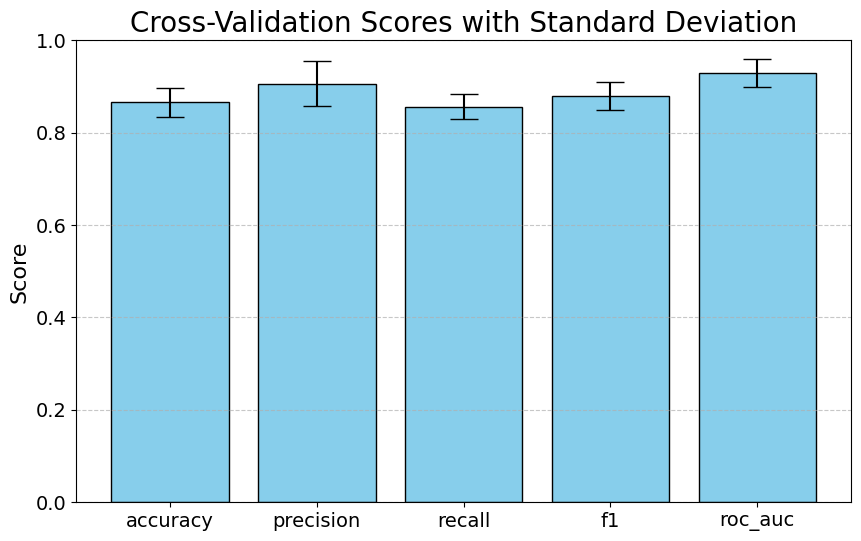

In [150]:
# Plot of Cross-Validation Scores
plt.figure(figsize=(10, 6))
plt.bar(metrics, means, yerr=stds, capsize=10, color="skyblue", edgecolor="black")
plt.ylim(0, 1)
plt.title("Cross-Validation Scores with Standard Deviation", fontsize=20)
plt.ylabel("Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [152]:
# Fit final model with reduced features
final_rf.fit(X_reduced, y)

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=12, n_estimators=300, random_state=42)

In [153]:
# Save final model
joblib.dump(final_rf, "../../models/rf_model.pkl")

['../../models/rf_model.pkl']